In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Enabling the GPU usage for tensorflow

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print('Amount of GPUs :', len(gpu_devices))
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Amount of GPUs : 1


# Importing Android Malware traffic datasets

In [3]:
# Importing dataset
dataset = pd.read_csv('datasets/driodcollector/android_traffic.csv', sep=";")
pd.set_option("display.max_columns", None)

# Data Refinement

### Displaying data dimensions

In [4]:
print('Dimension: ', dataset.shape)
dataset.head(3)

Dimension:  (7845, 17)


,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign


In [5]:
print('If True, it contains NaNs: '+ str(dataset.isnull().values.any())) # this is checking entire dataframe
dataset.isnull().sum().sum()
print(dataset.info())

If True, it contains NaNs: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  7845 non-null   object 
 1   tcp_packets           7845 non-null   int64  
 2   dist_port_tcp         7845 non-null   int64  
 3   external_ips          7845 non-null   int64  
 4   vulume_bytes          7845 non-null   int64  
 5   udp_packets           7845 non-null   int64  
 6   tcp_urg_packet        7845 non-null   int64  
 7   source_app_packets    7845 non-null   int64  
 8   remote_app_packets    7845 non-null   int64  
 9   source_app_bytes      7845 non-null   int64  
 10  remote_app_bytes      7845 non-null   int64  
 11  duracion              0 non-null      float64
 12  avg_local_pkt_rate    0 non-null      float64
 13  avg_remote_pkt_rate   0 non-null      float64
 14  source_app_packets.1  7845 non-null   in

In [6]:
print(dataset.shape)
dataset.describe()

(7845, 17)


,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,0.0,0.0,0.0,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,NaN,NaN,NaN,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,NaN,NaN,NaN,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,NaN,NaN,NaN,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,NaN,NaN,NaN,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,NaN,NaN,NaN,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,NaN,NaN,NaN,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,NaN,NaN,NaN,37150.000000,913.000000


In [7]:
dataset['type'].value_counts()

benign       4704
malicious    3141
Name: type, dtype: int64

### Removing empty data columns

There are few empty data columns in dataset. They are (<b>avg_local_pkt_rate, avg_remote_pkt_rate, duracion</b>).

In [8]:
dataset.drop(['avg_local_pkt_rate', 'avg_remote_pkt_rate', 'duracion'], axis=1, inplace=True)

In [9]:
print('If True, it contains NaNs: '+ str(dataset.isnull().values.any()))
print(dataset.shape)
dataset.describe()

If True, it contains NaNs: False
(7845, 14)


,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,37150.000000,913.000000


## Data Pre-processing

### Numericalization 

In [10]:
# importing standard scaler
from sklearn.preprocessing import StandardScaler,LabelEncoder
standard_scaler = StandardScaler()

In [12]:
# extracting numerical value from dataframe
num_cols = dataset.select_dtypes(include=['float64','int64']).columns

# extracting object value from dataframe
obj_cols = dataset.select_dtypes(include=['object']).copy()

# scaling numeric data 
scaled_num = standard_scaler.fit_transform(dataset.select_dtypes(include=['float64','int64']))

# turn into dataframe
pd_scaled_num= pd.DataFrame(scaled_num, columns=num_cols)


# merging both numeric data and object data
dataset = pd.concat([pd_scaled_num, obj_cols], axis=1)

In [13]:
dataset.head(3)

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,name,type
0,-0.143441,-0.033652,0.086046,-0.153587,-0.040693,-0.015969,-0.146231,-0.151404,-0.140898,-0.155173,-0.146231,-0.100476,AntiVirus,benign
1,-0.039311,-0.149817,2.138859,0.084743,-0.040693,-0.015969,-0.031980,-0.082119,-0.125803,0.090261,-0.031980,0.322821,AntiVirus,benign
2,0.062249,-0.149817,1.112453,0.092488,-0.040693,-0.015969,0.066867,0.018064,-0.027559,0.096440,0.066867,0.216997,AntiVirus,benign


### Normalization

Normalization on type columns

In [14]:
print(dataset.type.value_counts())

benign       4704
malicious    3141
Name: type, dtype: int64


In [15]:
# map the label data
map_label = {'benign' : 0, 'malicious' : 1}
dataset['type'] = dataset['type'].apply(lambda v: map_label[v])

In [16]:
print('Unique Label data: ', dataset['type'].unique())
print(dataset.shape)
dataset.head(5)

Unique Label data:  [0 1]
(7845, 14)


,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,name,type
0,-0.143441,-0.033652,0.086046,-0.153587,-0.040693,-0.015969,-0.146231,-0.151404,-0.140898,-0.155173,-0.146231,-0.100476,AntiVirus,0
1,-0.039311,-0.149817,2.138859,0.084743,-0.040693,-0.015969,-0.031980,-0.082119,-0.125803,0.090261,-0.031980,0.322821,AntiVirus,0
2,0.062249,-0.149817,1.112453,0.092488,-0.040693,-0.015969,0.066867,0.018064,-0.027559,0.096440,0.066867,0.216997,AntiVirus,0
3,-0.182008,-0.149817,-0.598225,-0.190328,-0.040693,-0.015969,-0.187310,-0.176684,-0.143954,-0.193594,-0.187310,-0.206300,AntiVirus,0
4,-0.182008,-0.149817,-0.598225,-0.190414,-0.040693,-0.015969,-0.187310,-0.176684,-0.143954,-0.193679,-0.187310,-0.206300,AntiVirus,0


Normalizatoin on name columns

In [17]:
# importing standard scaler
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [18]:
a = len(dataset['name'].unique())
print (a)

114


In [19]:
dataset['name'] = label_encoder.fit_transform(dataset.select_dtypes(include=['object']).values.ravel())

In [20]:
print(dataset.shape)
dataset.head(3)

(7845, 14)


,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,name,type
0,-0.143441,-0.033652,0.086046,-0.153587,-0.040693,-0.015969,-0.146231,-0.151404,-0.140898,-0.155173,-0.146231,-0.100476,6,0
1,-0.039311,-0.149817,2.138859,0.084743,-0.040693,-0.015969,-0.031980,-0.082119,-0.125803,0.090261,-0.031980,0.322821,6,0
2,0.062249,-0.149817,1.112453,0.092488,-0.040693,-0.015969,0.066867,0.018064,-0.027559,0.096440,0.066867,0.216997,6,0


In [21]:
dataset = dataset.astype({"name": int})
dataset['name'].unique()

array([  6,  10, 113,  11,  12,  19,  30,  43,  47,  56,  61,  67,  68,
        73,  75,  85,  87,  88, 100, 102,   0,   1,   2,   3,   4,   5,
         7,   8,   9,  13,  14,  15,  16,  17,  18,  20,  21,  22,  23,
        24,  27,  28,  25,  26,  29,  31,  32,  33,  35,  36,  37,  34,
        38,  39,  40,  41,  42,  44,  45,  46,  48,  49,  50,  51,  52,
        53,  55,  54,  57,  58,  59,  60,  62,  63,  64,  65,  69,  70,
        66,  71,  72,  74,  76,  78,  79,  80,  81,  82,  83,  84,  86,
        77,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 101,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112])

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tcp_packets           7845 non-null   float64
 1   dist_port_tcp         7845 non-null   float64
 2   external_ips          7845 non-null   float64
 3   vulume_bytes          7845 non-null   float64
 4   udp_packets           7845 non-null   float64
 5   tcp_urg_packet        7845 non-null   float64
 6   source_app_packets    7845 non-null   float64
 7   remote_app_packets    7845 non-null   float64
 8   source_app_bytes      7845 non-null   float64
 9   remote_app_bytes      7845 non-null   float64
 10  source_app_packets.1  7845 non-null   float64
 11  dns_query_times       7845 non-null   float64
 12  name                  7845 non-null   int32  
 13  type                  7845 non-null   int64  
dtypes: float64(12), int32(1), int64(1)
memory usage: 827.5 KB


## Displaying SNS Heatmap Correlation

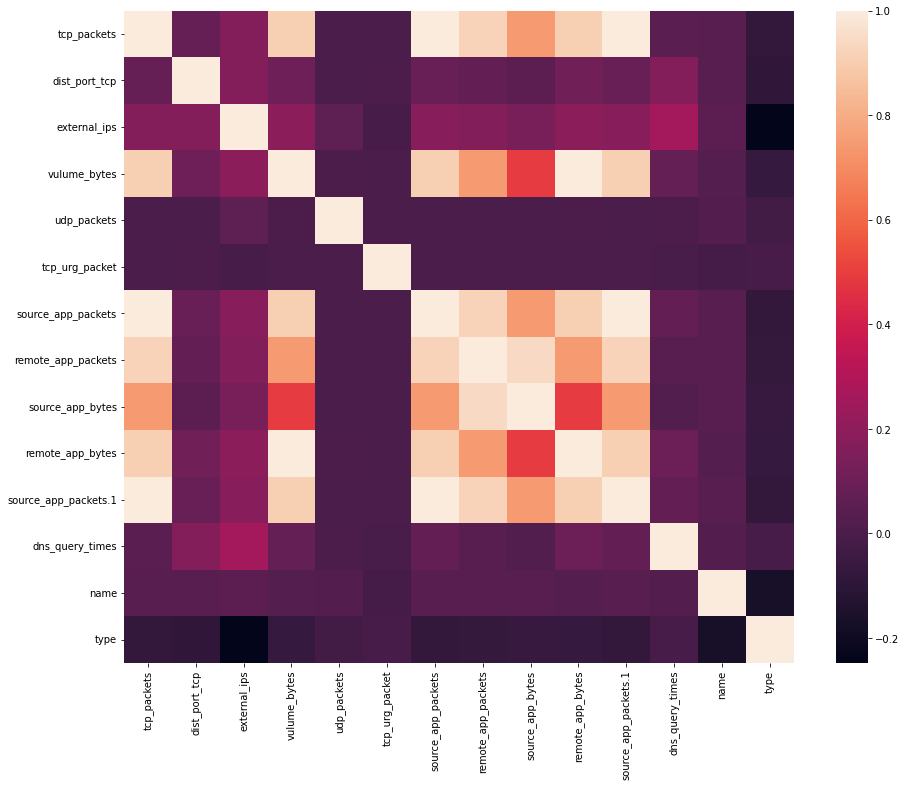

In [23]:
# correlation
corr = dataset.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

## Using Machine Learning Method

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
Y = dataset[['type']]
X = dataset.drop(['type'], axis =1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state =42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5256, 13) (5256, 1)
(2589, 13) (2589, 1)


In [26]:
# Gaussian Naive Bayes
import time
from sklearn.naive_bayes import GaussianNB
GNbayes = GaussianNB()

In [27]:
start_time = time.time()
GNbayes.fit(X_train, Y_train.values.ravel())
end_time = time.time()
print("Fiting time: ",end_time-start_time)

Fiting time:  0.00498652458190918


In [28]:
start_time = time.time()
prediction2 = GNbayes.predict(X_test)
end_time = time.time()
print("Prediction time: ",end_time-start_time)

Prediction time:  0.002991914749145508


In [29]:
# train score
score = (GNbayes.score(X_train, Y_train))*100
final1 = '{0:.4g}'.format(score)
# test score
score = (GNbayes.score(X_test,Y_test))*100
final2 = '{0:.4g}'.format(score)

In [30]:
print("Train score is:", final1, '%')
print("Test score is:", final2, '%')

Train score is: 44.22 %
Test score is: 44.3 %


## Using Multi-perceptron Layer Neural Network

In [31]:
# building neural network
keras.backend.clear_session()
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(Y_train.shape[1],activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'],  optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 3,763
Trainable params: 3,763
Non-trainable params: 0
______________________________________________________

In [32]:
# auto stopping training when it reach its limit
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto',
                           restore_best_weights=True)

In [33]:
# model training
training = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), callbacks=[monitor], verbose = 2, epochs=1000)

Epoch 1/1000
165/165 - 2s - loss: 0.6588 - accuracy: 0.6048 - val_loss: 0.6499 - val_accuracy: 0.6037
Epoch 2/1000
165/165 - 1s - loss: 0.6479 - accuracy: 0.6016 - val_loss: 0.6311 - val_accuracy: 0.5979
Epoch 3/1000
165/165 - 1s - loss: 0.6283 - accuracy: 0.6315 - val_loss: 0.6050 - val_accuracy: 0.6539
Epoch 4/1000
165/165 - 1s - loss: 0.6142 - accuracy: 0.6471 - val_loss: 0.5921 - val_accuracy: 0.6771
Epoch 5/1000
165/165 - 1s - loss: 0.6001 - accuracy: 0.6712 - val_loss: 0.5849 - val_accuracy: 0.6906
Epoch 6/1000
165/165 - 1s - loss: 0.5878 - accuracy: 0.6979 - val_loss: 0.5753 - val_accuracy: 0.7014
Epoch 7/1000
165/165 - 1s - loss: 0.5799 - accuracy: 0.6943 - val_loss: 0.5707 - val_accuracy: 0.7018
Epoch 8/1000
165/165 - 1s - loss: 0.5713 - accuracy: 0.6967 - val_loss: 0.5858 - val_accuracy: 0.6694
Epoch 9/1000
165/165 - 1s - loss: 0.5620 - accuracy: 0.7093 - val_loss: 0.5474 - val_accuracy: 0.7277
Epoch 10/1000
165/165 - 1s - loss: 0.5502 - accuracy: 0.7224 - val_loss: 0.5398 - 

In [34]:
# Validation score on test data
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print(f"Validation score: {score}")

Validation score: 1.0
